In [1]:
import pandas as pd
df = pd.read_csv("After_preprocessing.csv")

# Convert the 'Date' column to datetime
df["Date"] = pd.to_datetime(df['Date'])

# Create a new column 'PandemicPhase' based on the date
df['PandemicPhase'] = df['Date'].apply(lambda x: "Before Pandemic" if x < pd.to_datetime('2020-03-11') else "After Pandemic")

# Transform 'PandemicPhase' into binary format
df['PandemicPhase'] = df['PandemicPhase'].apply(lambda x: 1 if x == "After Pandemic" else 0)


# Calculate the close-to-close returns
df['Returns'] = df['Close'].pct_change()

# Calculate the volatility as the rolling standard deviation of the past 5 days returns
df['Volatility'] = df['Returns'].rolling(window=5).std()

# Extract year, month, and day from the 'Date' column
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Weekday'] = df['Date'].dt.weekday # Monday is 0 and Sunday is 6.

# Create a new column 'PositiveReturn' which is True if 'Returns' is positive and False otherwise
df['PositiveReturn'] = df['Returns'] > 0

# Convert 'PositiveReturn' into binary format
df['PositiveReturn'] = df['PositiveReturn'].astype(int)

#Drop "Return" column
df.drop("Returns", axis=1, inplace=True)

df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,Sentiment_Score,New_Covid_Cases,MarketCap,PandemicPhase,Volatility,Year,Month,Weekday,PositiveReturn
0,2013-04-30,32.560001,33.110001,32.279999,33.099998,27.390682,75165200,MSFT,5.60,0.0,2424341266432,0,NaN,2013,4,1,0
1,2013-05-01,32.930000,33.080002,32.599998,32.720001,27.076227,54330900,MSFT,0.04,0.0,2424341266432,0,NaN,2013,5,2,0
2,2013-05-02,32.630001,33.169998,32.389999,33.160000,27.440329,46059500,MSFT,3.02,0.0,2424341266432,0,NaN,2013,5,3,1
3,2013-05-03,33.230000,33.520000,33.080002,33.490002,27.713415,46784600,MSFT,2.66,0.0,2424341266432,0,NaN,2013,5,4,1
4,2013-05-06,33.419998,33.910000,33.250000,33.750000,27.928564,40978300,MSFT,2.20,0.0,2424341266432,0,NaN,2013,5,0,1


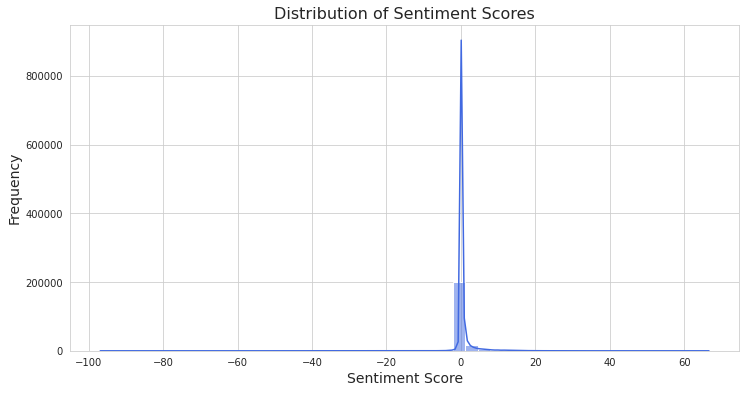

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for seaborn plots
sns.set_style("whitegrid")

# Plot distribution of Sentiment_Score
plt.figure(figsize=(12, 6))
sns.histplot(df['Sentiment_Score'], bins=50, color='royalblue', kde=True)
plt.title('Distribution of Sentiment Scores', fontsize=16)
plt.xlabel('Sentiment Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()


# Model

In [2]:
from sklearn.preprocessing import LabelEncoder

# Drop the first 5 rows
df = df.iloc[5:]

# # Create a label encoder
# le = LabelEncoder()

# # Fit the encoder to the 'Ticker' column and transform it
# df['Ticker'] = le.fit_transform(df['Ticker'])

## Random Forest

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score


# Drop the 'Date' and 'PositiveReturn' columns from the features
X = df.drop(columns=['Date', 'PositiveReturn'])

# Use the 'PositiveReturn' column as the target
y = df['PositiveReturn']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Dictionary to store AUC scores for each ticker
ticker_auc_scores = {}

# Dictionary to store trained Random Forest models for each ticker
ticker_rf_models = {}

# Iterate over each unique ticker
for ticker in df['Ticker'].unique():
    
    # Subset data for the current ticker
    df_ticker = df[df['Ticker'] == ticker]
    
    # Drop the 'Date', 'PositiveReturn' and 'Ticker' columns from the features
    X = df_ticker.drop(columns=['Date', 'PositiveReturn', 'Ticker'])
    
    # Use the 'PositiveReturn' column as the target
    y = df_ticker['PositiveReturn']
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create a RandomForest model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    
    # Train the model
    rf_model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred_rf = rf_model.predict_proba(X_test)[:, 1]
    
    # Compute the AUC score
    auc_score = roc_auc_score(y_test, y_pred_rf)
    
    # Store the AUC score and model in dictionaries
    ticker_auc_scores[ticker] = auc_score
    ticker_rf_models[ticker] = rf_model

ticker_auc_scores


{'MSFT': 0.6340168494674933,
 'AAPL': 0.6417024162513406,
 'NVDA': 0.6269253930020284,
 'AMZN': 0.6250236443883983,
 'META': 0.5782116305443548,
 'TSLA': 0.7137084705178091,
 'GOOGL': 0.6437356911660219,
 'GOOG': 0.6612310844892811,
 'AVGO': 0.640167297979798,
 'COST': 0.6858729033782187,
 'ADBE': 0.6478599221789884,
 'CSCO': 0.6358046076563311,
 'NFLX': 0.7376182219419924,
 'AMD': 0.6220299993697612,
 'CMCSA': 0.6759706439393939,
 'TMUS': 0.6453409592235457,
 'TXN': 0.6424599924395161,
 'INTC': 0.6542016276575611,
 'HON': 0.625419800387872,
 'INTU': 0.6559570881708912,
 'QCOM': 0.629550186108132,
 'ISRG': 0.7084973024436687,
 'AMGN': 0.7062760847310812,
 'AMAT': 0.694912985274431,
 'SBUX': 0.6244466228181128,
 'BKNG': 0.7386320665532237,
 'ADI': 0.6503084423268068,
 'MDLZ': 0.7132121001829537,
 'GILD': 0.7501459381853178,
 'ADP': 0.6923924853943907,
 'VRTX': 0.7612335567923096,
 'LRCX': 0.6939044195323463,
 'PYPL': 0.6387049395758715,
 'REGN': 0.7443726355611602,
 'PANW': 0.6465699250

In [4]:
# import matplotlib.pyplot as plt
# plt.barh(X.columns, rf_model.feature_importances_)

## XGBoost

In [6]:
# from xgboost import XGBClassifier

# # Create an XGBoost classifier
# xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='auc')

# # Fit the model to the training data
# xgb_model.fit(
#     X_train, 
#     y_train, 
#     early_stopping_rounds=10, 
#     eval_set=[(X_test, y_test)]
# )


/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[0]	validation_0-auc:0.57138
[1]	validation_0-auc:0.57801
[2]	validation_0-auc:0.58137
[3]	validation_0-auc:0.58595
[4]	validation_0-auc:0.58751
[5]	validation_0-auc:0.59040
[6]	validation_0-auc:0.59463
[7]	validation_0-auc:0.59553
[8]	validation_0-auc:0.60218
[9]	validation_0-auc:0.60317
[10]	validation_0-auc:0.60961
[11]	validation_0-auc:0.61052
[12]	validation_0-auc:0.61845
[13]	validation_0-auc:0.61821
[14]	validation_0-auc:0.61905
[15]	validation_0-auc:0.62774
[16]	validation_0-auc:0.62835
[17]	validation_0-auc:0.63227
[18]	validation_0-auc:0.63308
[19]	validation_0-auc:0.63377
[20]	validation_0-auc:0.63788
[21]	validation_0-auc:0.64818
[22]	validation_0-auc:0.65620
[23]	validation_0-auc:0.66286
[24]	validation_0-auc:0.66902
[25]	validation_0-auc:0.67596
[26]	validation_0-auc:0.68228
[27]	validation_0-auc:0.69163
[28]	validation_0-auc:0.70351
[29]	validation_0-auc:0.71372
[30]	validation_0-auc:0.72444
[31]	validation_0-auc:0.73353
[32]	validation_0-auc:0.74130
[33]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [5]:
from xgboost import XGBClassifier

# Dictionary to store AUC scores for XGBoost for each ticker
ticker_auc_scores_xgb = {}

# Dictionary to store trained XGBoost models for each ticker
ticker_xgb_models = {}

# Iterate over each unique ticker
for ticker in df['Ticker'].unique():
    
    # Subset data for the current ticker
    df_ticker = df[df['Ticker'] == ticker]
    
    # Drop the 'Date', 'PositiveReturn' and 'Ticker' columns from the features
    X = df_ticker.drop(columns=['Date', 'PositiveReturn', 'Ticker'])
    
    # Use the 'PositiveReturn' column as the target
    y = df_ticker['PositiveReturn']
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create an XGBoost classifier
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='auc')
    
    # Fit the model to the training data
    xgb_model.fit(
        X_train, 
        y_train, 
        early_stopping_rounds=10, 
        eval_set=[(X_test, y_test)],
        verbose=False  # setting verbose to False to suppress output for each ticker
    )
    
    # Make predictions on the test set
    y_pred_xgb = xgb_model.predict_proba(X_test)[:, 1]
    
    # Compute the AUC score
    auc_score = roc_auc_score(y_test, y_pred_xgb)
    
    # Store the AUC score and model in dictionaries
    ticker_auc_scores_xgb[ticker] = auc_score
    ticker_xgb_models[ticker] = xgb_model

ticker_auc_scores_xgb


/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,
/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,
/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,
/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor

{'MSFT': 0.6807025910030201,
 'AAPL': 0.6771260488297268,
 'NVDA': 0.6878169371196755,
 'AMZN': 0.69468789407314,
 'META': 0.6771988407258065,
 'TSLA': 0.7835504655082784,
 'GOOGL': 0.6760006315623274,
 'GOOG': 0.7443095838587641,
 'AVGO': 0.7296243686868686,
 'COST': 0.7355539806283959,
 'ADBE': 0.6706312323760614,
 'CSCO': 0.7435081807158718,
 'NFLX': 0.826812736443884,
 'AMD': 0.7053869666603643,
 'CMCSA': 0.7905145202020202,
 'TMUS': 0.7614073233755592,
 'TXN': 0.732453377016129,
 'INTC': 0.7966532079994952,
 'HON': 0.701937782823266,
 'INTU': 0.6070117676711984,
 'QCOM': 0.7275250772821904,
 'ISRG': 0.7744049508092669,
 'AMGN': 0.7776754075124025,
 'AMAT': 0.7679029844869676,
 'SBUX': 0.6765747533518847,
 'BKNG': 0.8135123211697234,
 'ADI': 0.747629490557405,
 'MDLZ': 0.7955964923348685,
 'GILD': 0.8537620497609769,
 'ADP': 0.7411460875864133,
 'VRTX': 0.8283107766253477,
 'LRCX': 0.7214102139602352,
 'PYPL': 0.7093200030920662,
 'REGN': 0.8249369482976041,
 'PANW': 0.741869918699

In [ ]:
# from sklearn.metrics import roc_auc_score
# y_pred_xgb = xgb_model.predict_proba(X_test)
# print(f"xgboost AUC: {roc_auc_score(y_test, y_pred_xgb[:, 1])}")

<BarContainer object of 15 artists>

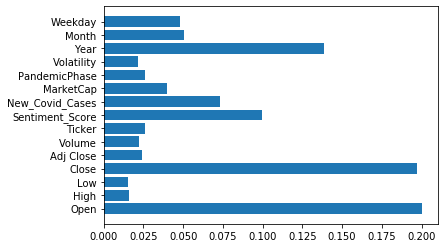

In [8]:
# import matplotlib.pyplot as plt
# plt.barh(X.columns, xgb_model.feature_importances_)

## LightGBM

In [8]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Dictionary to store AUC scores for LightGBM for each ticker
ticker_auc_scores_lgbm = {}

# Dictionary to store trained LightGBM models for each ticker
ticker_lgbm_models = {}

# Iterate over each unique ticker
for ticker in df['Ticker'].unique():
    
    # Subset data for the current ticker
    df_ticker = df[df['Ticker'] == ticker]
    
    # Drop the 'Date', 'PositiveReturn' and 'Ticker' columns from the features
    X = df_ticker.drop(columns=['Date', 'PositiveReturn', 'Ticker'])
    
    # Use the 'PositiveReturn' column as the target
    y = df_ticker['PositiveReturn']
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create a LightGBM classifier
    lgbm_model = lgb.LGBMClassifier(boosting_type="goss", max_depth=5, random_state=0, n_jobs=1)
    
    # Fit the model to the training data
    lgbm_model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred_lgbm = lgbm_model.predict_proba(X_test)[:, 1]
    
    # Compute the AUC score
    auc_score = roc_auc_score(y_test, y_pred_lgbm)
    
    # Store the AUC score and model in dictionaries
    ticker_auc_scores_lgbm[ticker] = auc_score
    ticker_lgbm_models[ticker] = lgbm_model

# Display the AUC scores
print("*******************************************************")
print(ticker_auc_scores_lgbm)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 1052, number of negative: 958
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003347 seconds.
You can set `force_row_wise=true` to remove the overhead.
A

In [11]:
# y_pred_lgbmc = lgbmc_model.predict_proba(X_test)
# print(f"light gbm AUC: {roc_auc_score(y_test, y_pred_lgbmc[:, 1])}")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
light gbm AUC: 0.7174908869120981


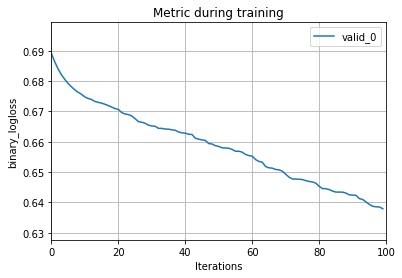

In [12]:
# # learning curve
# lgb.plot_metric(lgbmc_model)

## CatBoost

In [13]:
# from catboost import CatBoostClassifier
# cbc_model = CatBoostClassifier(iterations=1000, learning_rate=0.01)
# eval_set = [(X_test, y_test)]
# cbc_model.fit(X_train, y_train, eval_set=eval_set, early_stopping_rounds=10, verbose=True)

0:	learn: 0.6927538	test: 0.6927762	best: 0.6927762 (0)	total: 851ms	remaining: 14m 10s
1:	learn: 0.6923905	test: 0.6924249	best: 0.6924249 (1)	total: 1.16s	remaining: 9m 41s
2:	learn: 0.6920577	test: 0.6920824	best: 0.6920824 (2)	total: 1.5s	remaining: 8m 18s
3:	learn: 0.6917302	test: 0.6917765	best: 0.6917765 (3)	total: 1.8s	remaining: 7m 28s
4:	learn: 0.6913978	test: 0.6914559	best: 0.6914559 (4)	total: 2.11s	remaining: 6m 59s
5:	learn: 0.6910793	test: 0.6911544	best: 0.6911544 (5)	total: 2.42s	remaining: 6m 40s
6:	learn: 0.6907397	test: 0.6908227	best: 0.6908227 (6)	total: 2.7s	remaining: 6m 22s
7:	learn: 0.6903962	test: 0.6904850	best: 0.6904850 (7)	total: 3.01s	remaining: 6m 12s
8:	learn: 0.6900822	test: 0.6901783	best: 0.6901783 (8)	total: 3.3s	remaining: 6m 3s
9:	learn: 0.6897850	test: 0.6898888	best: 0.6898888 (9)	total: 3.63s	remaining: 5m 58s
10:	learn: 0.6894578	test: 0.6895706	best: 0.6895706 (10)	total: 3.93s	remaining: 5m 53s
11:	learn: 0.6891257	test: 0.6892478	best: 0.

In [7]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Dictionary to store AUC scores for CatBoost for each ticker
ticker_auc_scores_cbc = {}

# Dictionary to store trained CatBoost models for each ticker
ticker_cbc_models = {}

# Iterate over each unique ticker
for ticker in df['Ticker'].unique():
    
    # Subset data for the current ticker
    df_ticker = df[df['Ticker'] == ticker]
    
    # Drop the 'Date', 'PositiveReturn' and 'Ticker' columns from the features
    X = df_ticker.drop(columns=['Date', 'PositiveReturn', 'Ticker'])
    
    # Use the 'PositiveReturn' column as the target
    y = df_ticker['PositiveReturn']
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create a CatBoost classifier
    cbc_model = CatBoostClassifier(iterations=1000, learning_rate=0.01, verbose=0)  # verbose=0 to suppress output
    
    # Fit the model to the training data
    cbc_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=10)
    
    # Make predictions on the test set
    y_pred_cbc = cbc_model.predict_proba(X_test)[:, 1]
    
    # Compute the AUC score
    auc_score = roc_auc_score(y_test, y_pred_cbc)
    
    # Store the AUC score and model in dictionaries
    ticker_auc_scores_cbc[ticker] = auc_score
    ticker_cbc_models[ticker] = cbc_model

# Display the AUC scores
print(ticker_auc_scores_cbc)


{'MSFT': 0.5924495310761406, 'AAPL': 0.688552772695729, 'NVDA': 0.6137962728194726, 'AMZN': 0.5807061790668347, 'META': 0.5284620715725806, 'TSLA': 0.650089005812946, 'GOOGL': 0.5853477540064735, 'GOOG': 0.5896752837326606, 'AVGO': 0.553945707070707, 'COST': 0.6626506024096386, 'ADBE': 0.5711337607712786, 'CSCO': 0.594318378659276, 'NFLX': 0.696374527112232, 'AMD': 0.6030125417533245, 'CMCSA': 0.5840672348484849, 'TMUS': 0.5757389550639692, 'TXN': 0.5963489163306451, 'INTC': 0.625796479717368, 'HON': 0.5636441038739889, 'INTU': 0.632807700184313, 'QCOM': 0.5883698189388682, 'ISRG': 0.684401777213583, 'AMGN': 0.6439404677533664, 'AMAT': 0.6569493660918183, 'SBUX': 0.5868011636731596, 'BKNG': 0.7266654061889456, 'ADI': 0.608301910606945, 'MDLZ': 0.6428931928584948, 'GILD': 0.7296435952858022, 'ADP': 0.6387099822055651, 'VRTX': 0.6597204654692639, 'LRCX': 0.6112293647414975, 'PYPL': 0.6211445798654951, 'REGN': 0.7527269861286254, 'PANW': 0.4776895443373039, 'MU': 0.6228346456692914, 'CSX'

In [14]:
# y_pred_cbc = cbc_model.predict_proba(X_test)
# print(f"catboost AUC: {roc_auc_score(y_test, y_pred_cbc[:, 1])}")

catboost AUC: 0.7282137244645017


In [9]:
import pandas as pd 

In [10]:
random_forest_auc = {
    
'MSFT': 0.6340168494674933,
 'AAPL': 0.6417024162513406,
 'NVDA': 0.6269253930020284,
 'AMZN': 0.6250236443883983,
 'META': 0.5782116305443548,
 'TSLA': 0.7137084705178091,
 'GOOGL': 0.6437356911660219,
 'GOOG': 0.6612310844892811,
 'AVGO': 0.640167297979798,
 'COST': 0.6858729033782187,
 'ADBE': 0.6478599221789884,
 'CSCO': 0.6358046076563311,
 'NFLX': 0.7376182219419924,
 'AMD': 0.6220299993697612,
 'CMCSA': 0.6759706439393939,
 'TMUS': 0.6453409592235457,
 'TXN': 0.6424599924395161,
 'INTC': 0.6542016276575611,
 'HON': 0.625419800387872,
 'INTU': 0.6559570881708912,
 'QCOM': 0.629550186108132,
 'ISRG': 0.7084973024436687,
 'AMGN': 0.7062760847310812,
 'AMAT': 0.694912985274431,
 'SBUX': 0.6244466228181128,
 'BKNG': 0.7386320665532237,
 'ADI': 0.6503084423268068,
 'MDLZ': 0.7132121001829537,
 'GILD': 0.7501459381853178,
 'ADP': 0.6923924853943907,
 'VRTX': 0.7612335567923096,
 'LRCX': 0.6939044195323463,
 'PYPL': 0.6387049395758715,
 'REGN': 0.7443726355611602,
 'PANW': 0.6465699250015756,
 'MU': 0.6848661417322834,
 'CSX': 0.6778026234981024,
 'SNPS': 0.6269975170306233,
 'KLAC': 0.6760718789407313,
 'ASML': 0.5370344110417848,
 'CDNS': 0.6380359394703656,
 'FTNT': 0.6191936617468532,
 'ORLY': 0.6829208701134931,
 'MNST': 0.7426105853266775,
 'MAR': 0.7137996368516619,
 'CHTR': 0.7177494290889045,
 'MELI': 0.6046854082998661,
 'ABNB': 0.7119444444444446,
 'NXPI': 0.6559110970996217,
 'MRVL': 0.6481741020109285,
 'DXCM': 0.7114134303567191,
 'CTAS': 0.6013374485596708,
 'MCHP': 0.6594298763682179,
 'MRNA': 0.7187294543063775,
 'LULU': 0.6677411727616644,
 'ADSK': 0.7222914661660066,
 'PDD': 0.612056392805056,
 'WDAY': 0.6956731301063547,
 'PCAR': 0.7205055516182375,
 'AEP': 0.6834401524337432,
 'KDP': 0.6710323210685485,
 'KHC': 0.667464114832536,
 'IDXX': 0.6294390814103277,
 'CPRT': 0.7164555366483897,
 'PAYX': 0.6741218637992832,
 'ON': 0.6543064656193258,
 'EXC': 0.7564363143631436,
 'ODFL': 0.6971072036301759,
 'BIIB': 0.7893204802549578,
 'AZN': 0.5270964691046658,
 'ROST': 0.6784999763701381,
 'GEHC': 0.7222222222222222,
 'EA': 0.7270282632010598,
 'SGEN': 0.759825189719641,
 'CSGP': 0.6840400378310215,
 'GFS': 0.8119747899159664,
 'XEL': 0.7318860008832251,
 'BKR': 0.6850506489395378,
 'CTSH': 0.7262846784363178,
 'FAST': 0.7130323840725806,
 'VRSK': 0.6546810756313112,
 'CRWD': 0.6501093408309904,
 'DLTR': 0.7581758864798948,
 'WBD': 0.7778976377952755,
 'DDOG': 0.5616165277274374,
 'CEG': 0.5733590733590734,
 'ILMN': 0.6608742894036502,
 'ANSS': 0.6661482592563354,
 'ALGN': 0.7101993575207861,
 'TEAM': 0.677745245825603,
 'WBA': 0.7314072370390208,
 'FANG': 0.7229076069830467,
 'ENPH': 0.6831591063178973,
 'EBAY': 0.6352652058160967,
 'ZS': 0.6165286258388247,
 'SIRI': 0.786764705882353,
 'ZM': 0.7100331836814366,
 'JD': 0.6326615375487035,
 'LCID': 0.7063033941353037
}

In [11]:
xgboost_auc = {
 'MSFT': 0.6807025910030201,
 'AAPL': 0.6771260488297268,
 'NVDA': 0.6878169371196755,
 'AMZN': 0.69468789407314,
 'META': 0.6771988407258065,
 'TSLA': 0.7835504655082784,
 'GOOGL': 0.6760006315623274,
 'GOOG': 0.7443095838587641,
 'AVGO': 0.7296243686868686,
 'COST': 0.7355539806283959,
 'ADBE': 0.6706312323760614,
 'CSCO': 0.7435081807158718,
 'NFLX': 0.826812736443884,
 'AMD': 0.7053869666603643,
 'CMCSA': 0.7905145202020202,
 'TMUS': 0.7614073233755592,
 'TXN': 0.732453377016129,
 'INTC': 0.7966532079994952,
 'HON': 0.701937782823266,
 'INTU': 0.6070117676711984,
 'QCOM': 0.7275250772821904,
 'ISRG': 0.7744049508092669,
 'AMGN': 0.7776754075124025,
 'AMAT': 0.7679029844869676,
 'SBUX': 0.6765747533518847,
 'BKNG': 0.8135123211697234,
 'ADI': 0.747629490557405,
 'MDLZ': 0.7955964923348685,
 'GILD': 0.8537620497609769,
 'ADP': 0.7411460875864133,
 'VRTX': 0.8283107766253477,
 'LRCX': 0.7214102139602352,
 'PYPL': 0.7093200030920662,
 'REGN': 0.8249369482976041,
 'PANW': 0.7418699186991871,
 'MU': 0.7343622047244095,
 'CSX': 0.7957261861644331,
 'SNPS': 0.6730518240275036,
 'KLAC': 0.7492197351828499,
 'ASML': 0.5805366483897397,
 'CDNS': 0.584985813366961,
 'FTNT': 0.6639991054884671,
 'ORLY': 0.7200031525851198,
 'MNST': 0.7519644741193329,
 'MAR': 0.789310807610326,
 'CHTR': 0.7945665012993148,
 'MELI': 0.7422159225135837,
 'ABNB': 0.815,
 'NXPI': 0.7228247162673394,
 'MRVL': 0.6569847093838086,
 'DXCM': 0.8026101399984182,
 'CTAS': 0.6270971826527382,
 'MCHP': 0.7390030711079614,
 'MRNA': 0.8269230769230769,
 'LULU': 0.7509142496847414,
 'ADSK': 0.7953236672293833,
 'PDD': 0.6551149385373984,
 'WDAY': 0.7907204601842635,
 'PCAR': 0.7851326876131979,
 'AEP': 0.8302284931420563,
 'KDP': 0.7758631552419355,
 'KHC': 0.7541704383809646,
 'IDXX': 0.6852844351850379,
 'CPRT': 0.7304310833806013,
 'PAYX': 0.7493588211867781,
 'ON': 0.7295729059761585,
 'EXC': 0.8572981660049158,
 'ODFL': 0.7481880632759816,
 'BIIB': 0.8737516368742406,
 'AZN': 0.5999921185372005,
 'ROST': 0.8118275335150207,
 'GEHC': 0.7944444444444445,
 'EA': 0.76331146299918,
 'SGEN': 0.8415505734976257,
 'CSGP': 0.7883669609079444,
 'GFS': 0.9107142857142857,
 'XEL': 0.842328559712321,
 'BKR': 0.8227128838239949,
 'CTSH': 0.8010403530895334,
 'FAST': 0.7801080519153225,
 'VRSK': 0.7268860568061879,
 'CRWD': 0.7255024471519317,
 'DLTR': 0.8053228386361116,
 'WBD': 0.8417952755905511,
 'DDOG': 0.6861785671136886,
 'CEG': 0.6496138996138996,
 'ILMN': 0.7878682896871013,
 'ANSS': 0.7744059366858768,
 'ALGN': 0.7872889896699421,
 'TEAM': 0.753333719851577,
 'WBA': 0.771073898454607,
 'FANG': 0.8231234637927776,
 'ENPH': 0.7453210980243761,
 'EBAY': 0.7801162589202728,
 'ZS': 0.7245329786590895,
 'SIRI': 0.9097112529222214,
 'ZM': 0.7705446027718134,
 'JD': 0.7108443266549316,
 'LCID': 0.7732625259755253

}

lightgbm_auc = {
    'MSFT': 0.5954061357494834, 'AAPL': 0.6403223771370892, 'NVDA': 0.6033373478701827, 'AMZN': 0.6043663303909206, 'META': 0.5794953377016129, 'TSLA': 0.621953716977268, 'GOOGL': 0.6392358095839583, 'GOOG': 0.631998738965952, 'AVGO': 0.5877051767676769, 'COST': 0.5979368454208992, 'ADBE': 0.5848863403645299, 'CSCO': 0.6469615608711401, 'NFLX': 0.7048865069356873, 'AMD': 0.5820728556122772, 'CMCSA': 0.6318181818181818, 'TMUS': 0.6135375307241444, 'TXN': 0.6546276461693549, 'INTC': 0.6641536811557631, 'HON': 0.6075556186241584, 'INTU': 0.6006553348351423, 'QCOM': 0.6266639328748975, 'ISRG': 0.6895271342430975, 'AMGN': 0.7110796125679187, 'AMAT': 0.6569336168202221, 'SBUX': 0.6059163926132052, 'BKNG': 0.7135564378899604, 'ADI': 0.6400769922534434, 'MDLZ': 0.6759352722225727, 'GILD': 0.7830017512582238, 'ADP': 0.6849125238177725, 'VRTX': 0.6843378446749305, 'LRCX': 0.6493858694795263, 'PYPL': 0.5925429668375892, 'REGN': 0.7137137452711222, 'PANW': 0.5932911073296779, 'MU': 0.6657952755905512, 'CSX': 0.6655433601562132, 'SNPS': 0.6018494938562424, 'KLAC': 0.6524590163934426, 'ASML': 0.5390590533812315, 'CDNS': 0.5895018915510718, 'FTNT': 0.5875343428534918, 'ORLY': 0.6156525851197983, 'MNST': 0.6707557123285514, 'MAR': 0.7196968500828924, 'CHTR': 0.7051736357193481, 'MELI': 0.5441215843767226, 'ABNB': 0.7061111111111111, 'NXPI': 0.6333701134930644, 'MRVL': 0.5825079130119837, 'DXCM': 0.6402594320968126, 'CTAS': 0.5941120607787274, 'MCHP': 0.6339711788329789, 'MRNA': 0.7082511505588428, 'LULU': 0.6344262295081968, 'ADSK': 0.7173532335168735, 'PDD': 0.5672616153899577, 'WDAY': 0.6495203780085019, 'PCAR': 0.7199622017481692, 'AEP': 0.691353164417429, 'KDP': 0.6373645413306451, 'KHC': 0.6217768007241691, 'IDXX': 0.5906582483818127, 'CPRT': 0.6315623621352492, 'PAYX': 0.6421505376344085, 'ON': 0.6090471303386753, 'EXC': 0.760304405369635, 'ODFL': 0.687370013235016, 'BIIB': 0.8129151349731, 'AZN': 0.5546658259773014, 'ROST': 0.6891570440618158, 'GEHC': 0.43333333333333335, 'EA': 0.6865655163712069, 'SGEN': 0.6867298802518026, 'CSGP': 0.6361759142496848, 'GFS': 0.8396358543417366, 'XEL': 0.6960917292284398, 'BKR': 0.6835707502374169, 'CTSH': 0.7075819672131147, 'FAST': 0.6766160534274194, 'VRSK': 0.6046724113486349, 'CRWD': 0.5995001562011871, 'DLTR': 0.6785867000300905, 'WBD': 0.7484566929133858, 'DDOG': 0.6063791228706054, 'CEG': 0.6274131274131275, 'ILMN': 0.6329307276821567, 'ANSS': 0.6122523091497591, 'ALGN': 0.645234945830184, 'TEAM': 0.6336966604823747, 'WBA': 0.7057924668000441, 'FANG': 0.7773523665469212, 'ENPH': 0.5919776737145831, 'EBAY': 0.6060902030592795, 'ZS': 0.5997823589867601, 'SIRI': 0.7811808934099955, 'ZM': 0.6772398984969744, 'JD': 0.6093233915468445, 'LCID': 0.6991456938351421
}

catboost_auc = {
    'MSFT': 0.5924495310761406, 'AAPL': 0.688552772695729, 'NVDA': 0.6137962728194726, 'AMZN': 0.5807061790668347, 'META': 0.5284620715725806, 'TSLA': 0.650089005812946, 'GOOGL': 0.5853477540064735, 'GOOG': 0.5896752837326606, 'AVGO': 0.553945707070707, 'COST': 0.6626506024096386, 'ADBE': 0.5711337607712786, 'CSCO': 0.594318378659276, 'NFLX': 0.696374527112232, 'AMD': 0.6030125417533245, 'CMCSA': 0.5840672348484849, 'TMUS': 0.5757389550639692, 'TXN': 0.5963489163306451, 'INTC': 0.625796479717368, 'HON': 0.5636441038739889, 'INTU': 0.632807700184313, 'QCOM': 0.5883698189388682, 'ISRG': 0.684401777213583, 'AMGN': 0.6439404677533664, 'AMAT': 0.6569493660918183, 'SBUX': 0.5868011636731596, 'BKNG': 0.7266654061889456, 'ADI': 0.608301910606945, 'MDLZ': 0.6428931928584948, 'GILD': 0.7296435952858022, 'ADP': 0.6387099822055651, 'VRTX': 0.6597204654692639, 'LRCX': 0.6112293647414975, 'PYPL': 0.6211445798654951, 'REGN': 0.7527269861286254, 'PANW': 0.4776895443373039, 'MU': 0.6228346456692914, 'CSX': 0.6302536888021039, 'SNPS': 0.5994938562424397, 'KLAC': 0.58390605296343, 'ASML': 0.552719480683179, 'CDNS': 0.5914564943253467, 'FTNT': 0.5515622004983707, 'ORLY': 0.614249684741488, 'MNST': 0.6328362439569785, 'MAR': 0.6225941422594142, 'CHTR': 0.6394046775336641, 'MELI': 0.5106150090558312, 'ABNB': 0.6861111111111111, 'NXPI': 0.6070302648171501, 'MRVL': 0.5151410169598286, 'DXCM': 0.5579213794194415, 'CTAS': 0.5939537828426718, 'MCHP': 0.5530356721001654, 'MRNA': 0.678007889546351, 'LULU': 0.5991172761664566, 'ADSK': 0.6429642017575691, 'PDD': 0.5102090422946038, 'WDAY': 0.5621770255535011, 'PCAR': 0.6567918733758563, 'AEP': 0.659512149032329, 'KDP': 0.5414881552419355, 'KHC': 0.6321220742273375, 'IDXX': 0.595842809204981, 'CPRT': 0.6113474506838091, 'PAYX': 0.6442214257268021, 'ON': 0.5803426225625642, 'EXC': 0.7192128316632003, 'ODFL': 0.6550072477468961, 'BIIB': 0.8416610132054336, 'AZN': 0.5438839848675914, 'ROST': 0.6435829171852109, 'GEHC': 0.5555555555555556, 'EA': 0.7031890732445902, 'SGEN': 0.7463515453670544, 'CSGP': 0.5623896595208071, 'GFS': 0.7149859943977591, 'XEL': 0.683915841271844, 'BKR': 0.6221747388414055, 'CTSH': 0.6933795712484238, 'FAST': 0.6339623235887096, 'VRSK': 0.5722522408985649, 'CRWD': 0.5934603769655316, 'DLTR': 0.6720776649826584, 'WBD': 0.7889606299212598, 'DDOG': 0.47027908662558904, 'CEG': 0.5120656370656371, 'ILMN': 0.5245106530400139, 'ANSS': 0.5909528696613247, 'ALGN': 0.6125598387503149, 'TEAM': 0.6099837662337663, 'WBA': 0.7171190472439704, 'FANG': 0.7448477973151824, 'ENPH': 0.571953392302477, 'EBAY': 0.5760330187936168, 'ZS': 0.5864820748443262, 'SIRI': 0.8226290516206483, 'ZM': 0.6589888737068125, 'JD': 0.5615494155574454, 'LCID': 0.6702839990764258
}

In [12]:
# Construct the dataframe
df = pd.DataFrame({
    'Ticker': list(random_forest_auc.keys()),
    'Random Forest': list(random_forest_auc.values()),
    'XGBoost': list(xgboost_auc.values()),
    'LightGBM': list(lightgbm_auc.values()),
    'CatBoost': list(catboost_auc.values())
})


In [13]:

# Save the dataframe to a CSV file
df.to_csv('model_auc.csv', index=False)


In [15]:
df

,Ticker,Random Forest,XGBoost,LightGBM,CatBoost
0,MSFT,0.634017,0.680703,0.595406,0.592450
1,AAPL,0.641702,0.677126,0.640322,0.688553
2,NVDA,0.626925,0.687817,0.603337,0.613796
3,AMZN,0.625024,0.694688,0.604366,0.580706
4,META,0.578212,0.677199,0.579495,0.528462
...,...,...,...,...,...
94,ZS,0.616529,0.724533,0.599782,0.586482
95,SIRI,0.786765,0.909711,0.781181,0.822629
96,ZM,0.710033,0.770545,0.677240,0.658989
97,JD,0.632662,0.710844,0.609323,0.561549


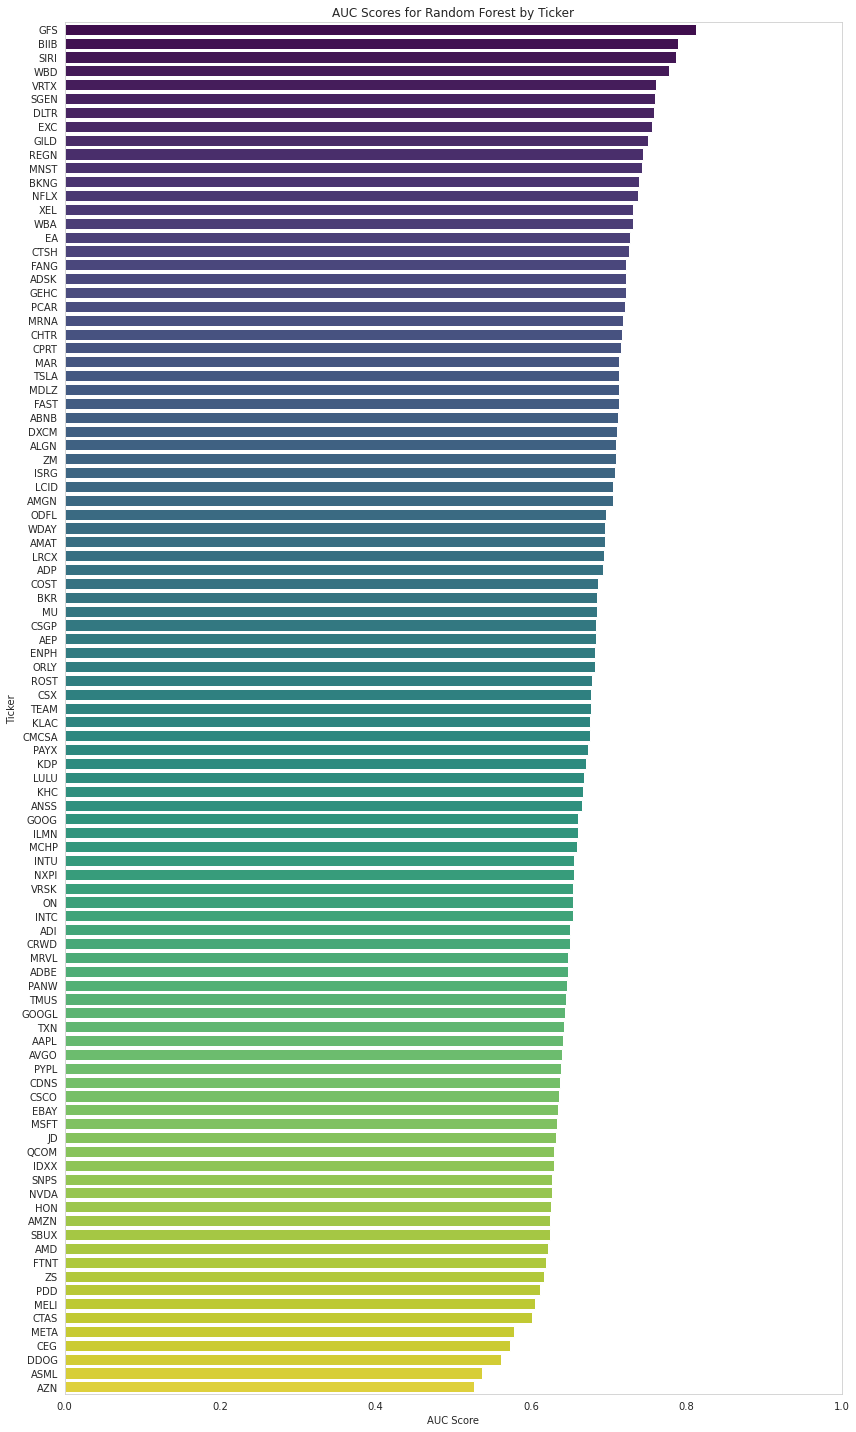

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
auc_data = pd.read_csv("model_auc.csv")

# Sort the data by the Random Forest AUC scores in descending order
sorted_auc_data = auc_data.sort_values(by='Random Forest', ascending=False)

# Plotting the AUC scores for Random Forest
plt.figure(figsize=(12, 20))
sns.barplot(data=sorted_auc_data, x='Random Forest', y='Ticker', palette="viridis")
plt.title('AUC Scores for Random Forest by Ticker')
plt.xlabel('AUC Score')
plt.ylabel('Ticker')
plt.xlim(0, 1)
plt.grid(axis='x')

plt.tight_layout()
plt.savefig("auc_plot_rf.png", format='png')
plt.show()

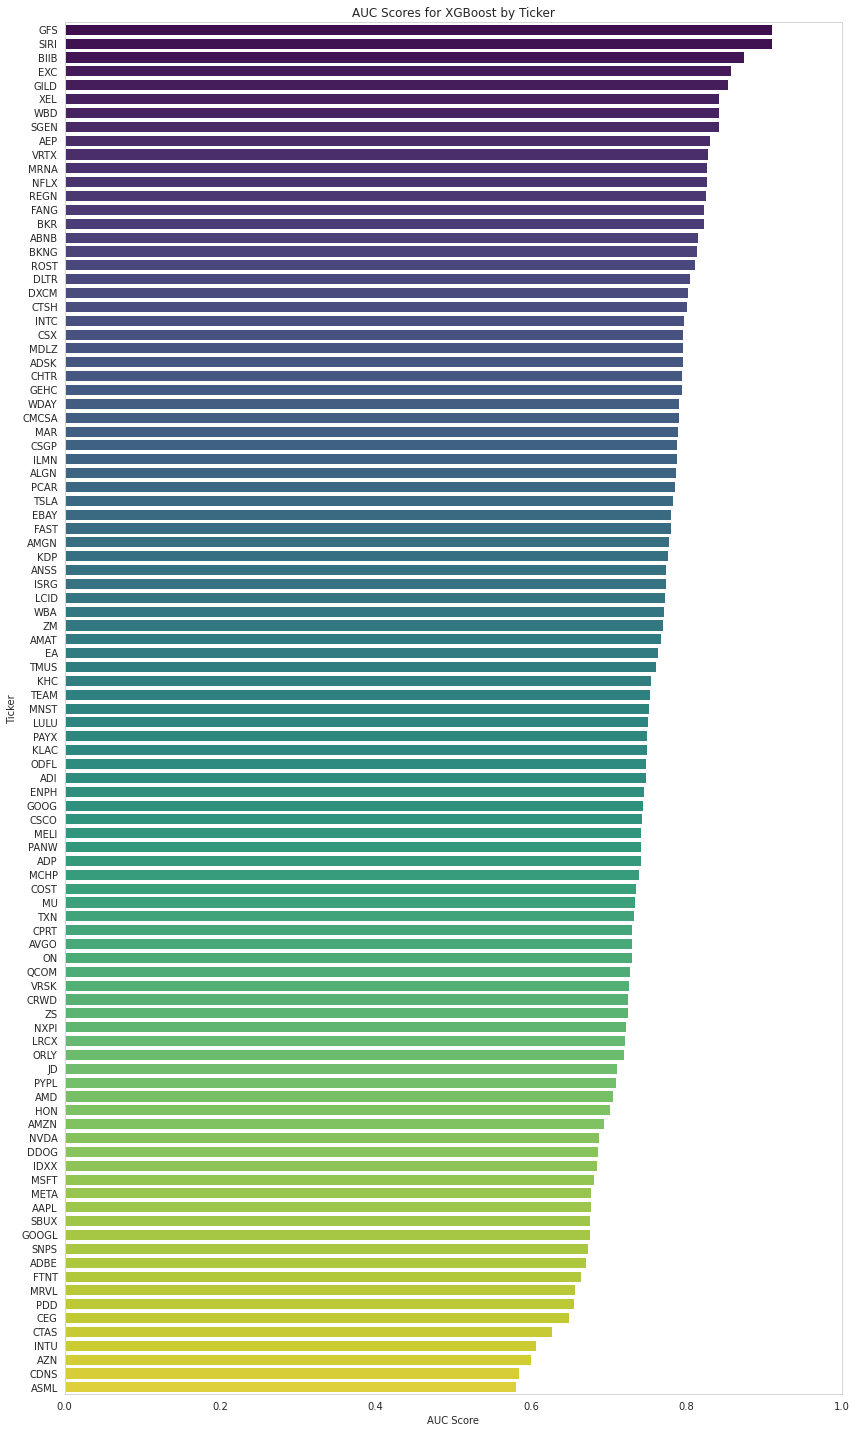

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
auc_data = pd.read_csv("model_auc.csv")

# Sort the data by the Random Forest AUC scores in descending order
sorted_auc_data = auc_data.sort_values(by='XGBoost', ascending=False)

# Plotting the AUC scores for Random Forest
plt.figure(figsize=(12, 20))
sns.barplot(data=sorted_auc_data, x='XGBoost', y='Ticker', palette="viridis")
plt.title('AUC Scores for XGBoost by Ticker')
plt.xlabel('AUC Score')
plt.ylabel('Ticker')
plt.xlim(0, 1)
plt.grid(axis='x')

plt.tight_layout()
plt.savefig("auc_plot_XGBoost.png", format='png')
plt.show()

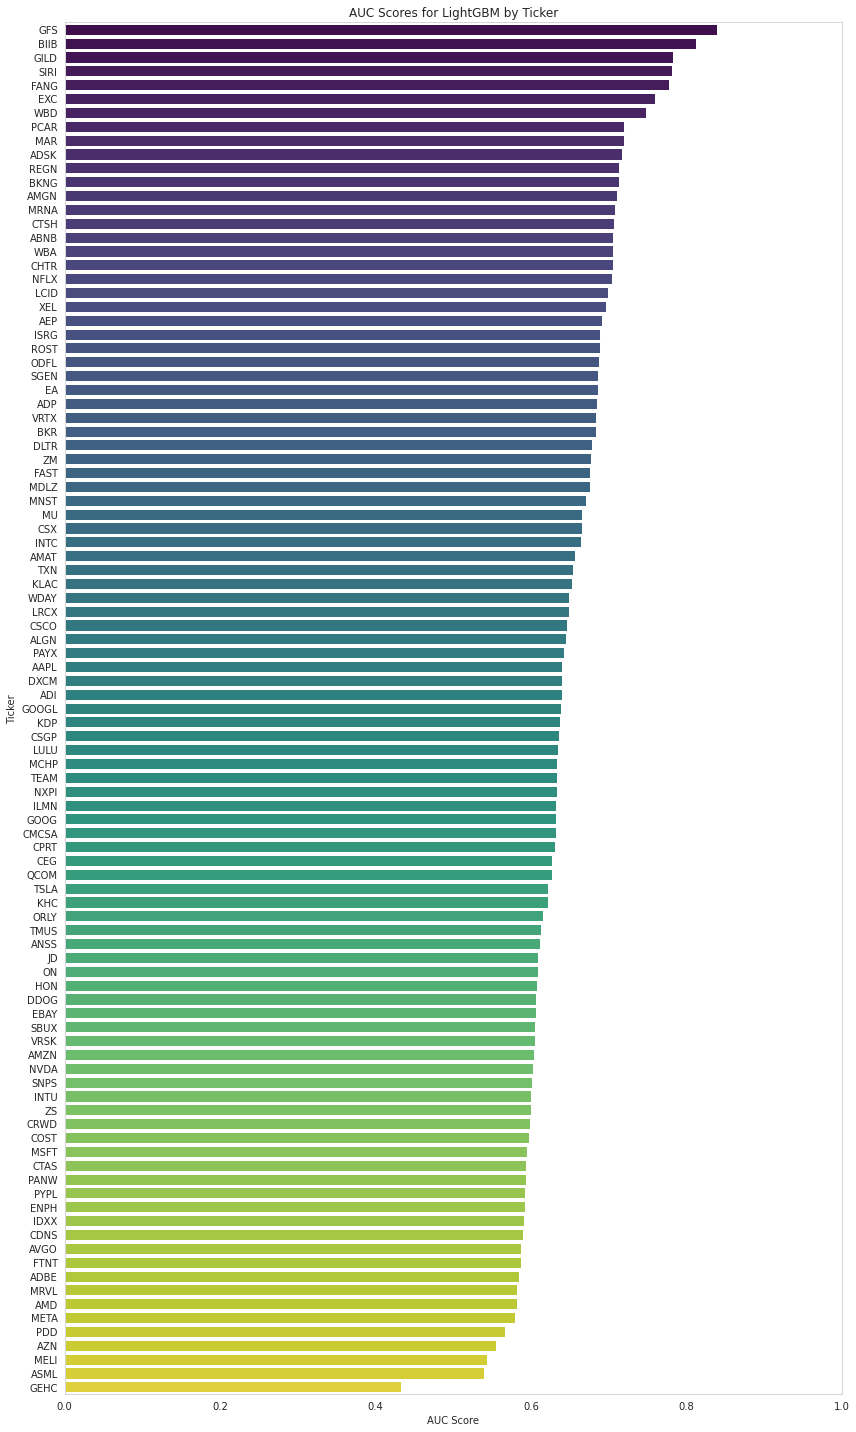

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
auc_data = pd.read_csv("model_auc.csv")

# Sort the data by the Random Forest AUC scores in descending order
sorted_auc_data = auc_data.sort_values(by='LightGBM', ascending=False)

# Plotting the AUC scores for Random Forest
plt.figure(figsize=(12, 20))
sns.barplot(data=sorted_auc_data, x='LightGBM', y='Ticker', palette="viridis")
plt.title('AUC Scores for LightGBM by Ticker')
plt.xlabel('AUC Score')
plt.ylabel('Ticker')
plt.xlim(0, 1)
plt.grid(axis='x')

plt.tight_layout()
plt.savefig("auc_plot_LightGBM.png", format='png')
plt.show()

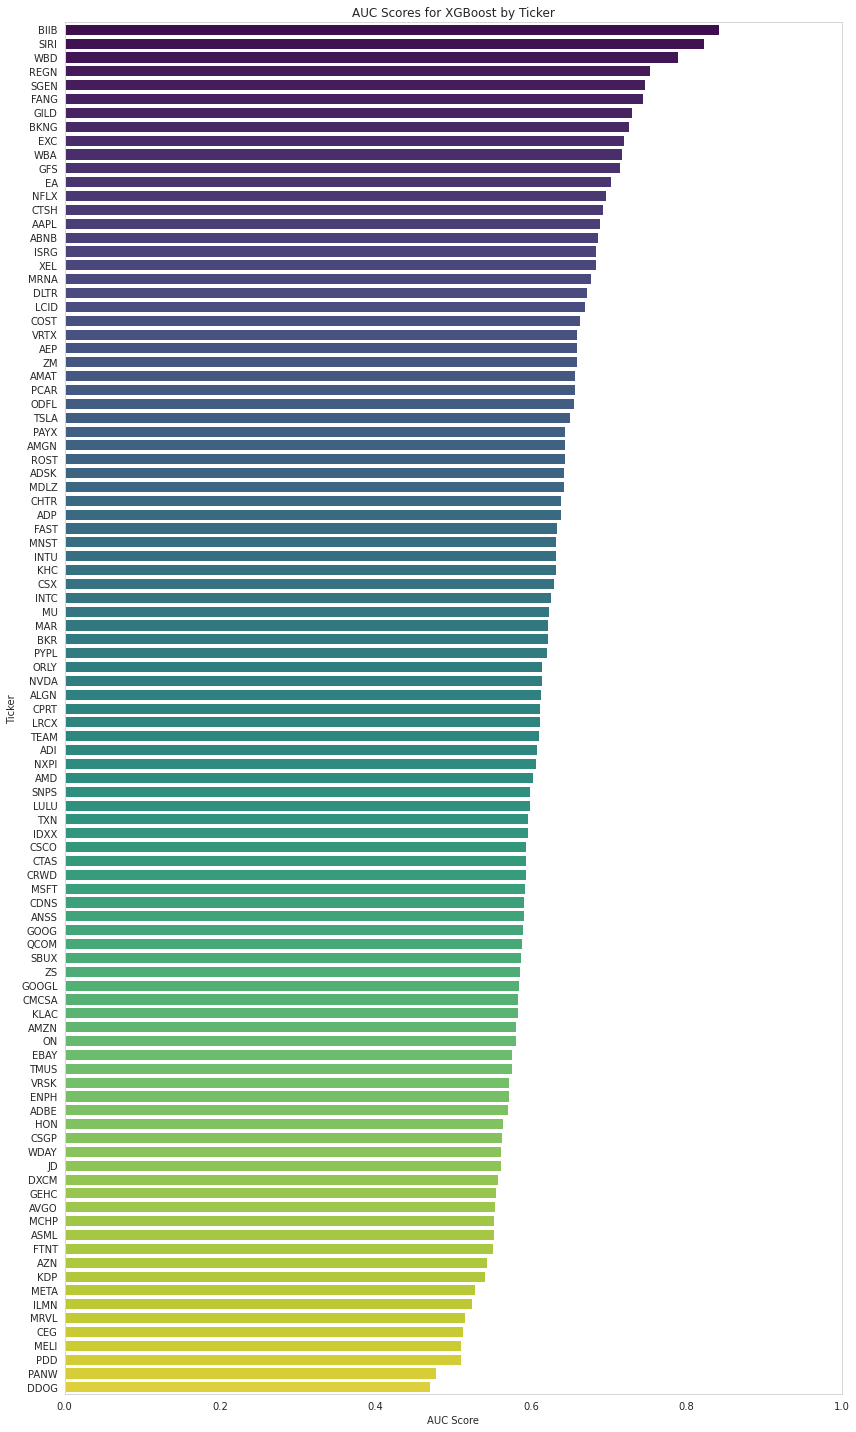

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
auc_data = pd.read_csv("model_auc.csv")

# Sort the data by the Random Forest AUC scores in descending order
sorted_auc_data = auc_data.sort_values(by='CatBoost', ascending=False)

# Plotting the AUC scores for Random Forest
plt.figure(figsize=(12, 20))
sns.barplot(data=sorted_auc_data, x='CatBoost', y='Ticker', palette="viridis")
plt.title('AUC Scores for XGBoost by Ticker')
plt.xlabel('AUC Score')
plt.ylabel('Ticker')
plt.xlim(0, 1)
plt.grid(axis='x')

plt.tight_layout()
plt.savefig("auc_plot_CatBoost.png", format='png')
plt.show()

In [33]:
import pandas as pd
import numpy as np

# Read the model AUC scores CSV
auc_data = pd.read_csv("model_auc.csv")

# Extract AUC scores for each model
rf_auc = auc_data['Random Forest'].values
xgb_auc = auc_data['XGBoost'].values
lgbm_auc = auc_data['LightGBM'].values
cbc_auc = auc_data['CatBoost'].values

# Calculate summary statistics for each model
summary_data = {
    'Model': ['Random Forest', 'XGBoost', 'LightGBM', 'CatBoost'],
    'Max AUC': [rf_auc.max(), xgb_auc.max(), lgbm_auc.max(), cbc_auc.max()],
    'Min AUC': [rf_auc.min(), xgb_auc.min(), lgbm_auc.min(), cbc_auc.min()],
    'Mean AUC': [rf_auc.mean(), xgb_auc.mean(), lgbm_auc.mean(), cbc_auc.mean()],
    'Median AUC': [np.median(rf_auc), np.median(xgb_auc), np.median(lgbm_auc), np.median(cbc_auc)]
}

# Create a DataFrame from the summary data
summary_df = pd.DataFrame(summary_data)

# Display the summary table
summary_df


,Model,Max AUC,Min AUC,Mean AUC,Median AUC
0,Random Forest,0.811975,0.527096,0.677326,0.677745
1,XGBoost,0.910714,0.580537,0.752619,0.751964
2,LightGBM,0.839636,0.433333,0.648179,0.639236
3,CatBoost,0.841661,0.470279,0.620946,0.611347


In [35]:
# To save this as a CSV for further analysis or inclusion in the paper
summary_df.to_csv("model_auc_summary.csv", index=False)
